In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses, Model
from tensorflow.keras.layers import Layer, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback, LambdaCallback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Activation
from tensorflow_addons.optimizers import AdamW
from layers import GatherIndices, GraphConvolution, AggregationLayer, SqueezedSparseConversion
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import os
import json
import zipfile
import shutil
from sklearn.manifold import TSNE
import pandas as pd
import geopandas as gpd

In [ ]:
building = gpd.read_file('./data/building.geojson')
adjs = np.load('./large_data/adjs.npy')
regions = gpd.read_file('./data/region.geojson')

In [13]:
building[['id', 'area', 'perimeter', 'floor']].to_csv('./data/building.csv')

<AxesSubplot:xlabel='floor', ylabel='Density'>

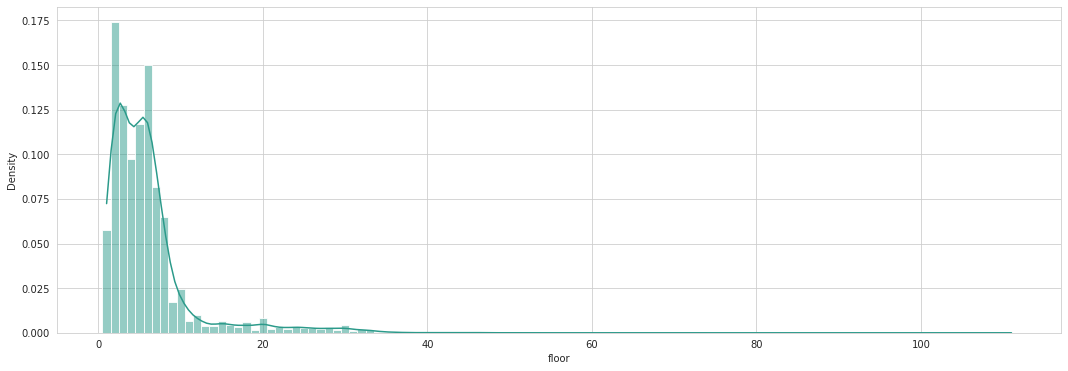

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(18,6))
sns.set_style('whitegrid')
sns.histplot(data=building['floor'], ax=ax, stat='density', discrete=True, kde=True, kde_kws={'bw_adjust': 2}, color='#2B9A8A')

<AxesSubplot:ylabel='Density'>

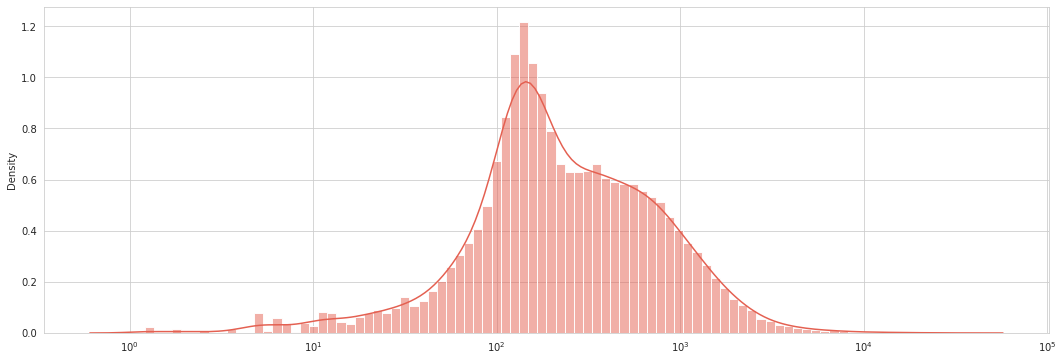

In [75]:
f, ax = plt.subplots(figsize=(18,6))
sns.set_style('whitegrid')
sns.histplot(data=pro_b.area, ax=ax, stat='density', discrete=False, bins=100, kde=True, kde_kws={'bw_adjust': 2},log_scale=True, color='#E46051')

In [81]:
building['floor'].var()

28.902668913772725

In [83]:
pro_b.area.std()

805.2766684802771

In [2]:
def zip(folder, file):
  z = zipfile.ZipFile(file, 'w', zipfile.ZIP_DEFLATED) 
  for dirpath, dirnames, filenames in os.walk(folder):
    fpath = dirpath.replace(folder,'') 
    fpath = fpath and fpath + os.sep or ''
    for filename in filenames:
        z.write(os.path.join(dirpath, filename),fpath+filename)
  z.close()


In [3]:
class Loss(Layer):
    def __init__(self, e=0.1, **kwargs):
        self.e = e
        super(Loss, self).__init__(**kwargs)
    
    def get_config(self):
        config = {}
        base_config = super.get_config()
        return {**base_config, **config}
    
    def compute_output_shape(self, input_shapes):
        return [1]
    
    def build(self, input_shapes):
        self.built = True
        
    def call(self, inputs):
        y_pred_all = inputs[0]
        y_true = inputs[1]
        out_indices = inputs[2]
        weight = inputs[3]
        feature = inputs[4]
        
        weight_pos = tf.clip_by_value(weight, 0, 1)
        weight_neg = tf.clip_by_value(weight, -1, 0)
        
        wp_neg = tf.multiply(tf.tile(tf.expand_dims(y_pred_all, 2), [1, 1, 1602, 1]), tf.tile(tf.expand_dims(weight_neg, 1), [1, 1514, 1, 1]))
        wp_pos = tf.multiply(tf.tile(tf.expand_dims((tf.ones_like(y_pred_all) - y_pred_all), 2), [1, 1, 1602, 1]), tf.tile(tf.expand_dims(weight_pos, 1), [1, 1514, 1, 1]))
        
        y_pred = GatherIndices(batch_dims=1)([y_pred_all, out_indices])
        
#         feature = (tf.exp(1 - feature) - 1) / (np.e - 1)
        
        expand_feature = tf.tile(tf.expand_dims(feature, 3), [1, 1, 1, 6])
        loss1 = losses.categorical_crossentropy(y_true, y_pred)
        loss2 = tf.reduce_sum(tf.multiply(wp_pos, expand_feature)) - tf.reduce_sum(tf.multiply(wp_neg, expand_feature))
        return [(1-self.e) * loss1 + self.e * loss2, y_pred]

In [4]:
class KuroModel:
    def __init__(self, id, embedding_size, layer_sizes, dropout, lr, wd, e, weights) -> None:
        self.id = id
        self.classes = ['C', 'G', 'M', 'P', 'R', 'U']
        self.embedding_size = embedding_size
        self.layer_sizes = layer_sizes
        self.dropout = dropout
        self.lr = lr
        self.wd = wd
        self.e = e
        self.weights = weights
        self.model = None
        self.result = None
        self.train_set = None
        self.int_grad = None

    def info(self):
      return {
        'params': {
          'embeddingSize': self.embedding_size,
          'gcnSize1': self.layer_sizes[0],
          'gcnSize2': self.layer_sizes[1],
          'dropout': self.dropout,
          'lr': self.lr,
          'wd': self.wd,
        },
        'id': self.id,
        'trainSet': list([np.int(i) for i in self.train_set]),
        'result': self.result
      }

    def save(self):
        if(os.path.exists(f'./models/{self.id}.zip')):
          return self.id
        dir = f'./models/{self.id}'
        os.mkdir(dir)
        self.model.save(f'{dir}/model')
        with open(f'{dir}/params.json', 'w+') as f:
            json.dump({
                'embeddingSize': self.embedding_size,
                'layerSizes': self.layer_sizes,
                'dropout': self.dropout,
                'lr': self.lr,
                'wd': self.wd,
                'trainSet': list([np.int(i) for i in self.train_set]),
                'result': self.result,
                'id': self.id
                }, f)
            f.close()
        zip(dir, f'./models/{self.id}.zip')
        shutil.rmtree(dir,ignore_errors=True)
        return self.id

    def load(self):
        dir = f'./models/{self.id}'
        if os.path.exists(dir):
            with open(f'{dir}/params.json', 'w+') as f:
                params = json.load(f)
                f.close()
            self.embedding_size = params['embeddingSize']
            self.layer_sizes = params['layerSizes']
            self.dropout = params['dropout']
            self.lr = params['lr']
            self.wd = params['wd']
            self.result = params['result']
            self.train_set = params['trainSet']
            self.model = tf.keras.models.load_model(f'{dir}/model')

    def encode(self, codes):
        out = []
        for code in codes:
            r = np.asanyarray([0, 0, 0, 0, 0, 0])
            r[self.classes.index(code)] = 1
            out.append(r)
        return np.asanyarray(out)
    
    def decode(self, codes):
        return np.asanyarray([self.classes[np.argmax(code)] for code in codes])

    def create_model(self):
        features=['LC', 'POI', 'Building', 'Mobility', 'Rhythm']
        n_features = [19, 17, 4, 1514, 48]
        # 网络输入[[features], indices, adj_indices, adj_values]
        feature_inputs = [layers.Input(batch_shape=(1, 1514, n_features[i]), name='Input_%s' % f) for i, f in enumerate(features)]
        out_indices = layers.Input(batch_shape=(1, None), dtype='int32', name='out_indices')
        adj_indices = layers.Input(batch_shape=(1, None, 2), dtype='int64', name='Adj_indices')
        adj_values = layers.Input(batch_shape=(1, None), name='Adj_values')
        target = layers.Input(batch_shape=(1, None, 6), name='target')
        weight = layers.Input(batch_shape=(1, 1602, 6), name='weight')
        x_input = [feature_inputs, out_indices, adj_indices, adj_values, target, weight]
        adj_inputs = SqueezedSparseConversion(shape=(1514, 1514), dtype=adj_values.dtype)([adj_indices, adj_values])
        x_outs = [layers.Dense(units=self.embedding_size, activation='relu', name=f'Hidden_%s' % features[i])(f) for i, f in enumerate(feature_inputs)]
        # x_outs = feature_inputs
        # 多通道图卷积
        x_outs = [layers.Dropout(self.dropout)(f) for f in x_outs]
        x_outs = [GraphConvolution(self.layer_sizes[0], activation='relu', name=f'GC_%s' % features[i])([f, adj_inputs]) for i, f in enumerate(x_outs)]
        x_out = AggregationLayer(activation='relu', method='pool', name='graph_avg')(x_outs)
        x_out = layers.Dropout(self.dropout)(x_out)
        x_out = GraphConvolution(self.layer_sizes[1], activation='relu', name='GC_2')([x_out, adj_inputs])

        # softmax多分类预测
        x_out = Activation('softmax')(layers.Dense(units=6, name='pred_score')(x_out)) 
        feature_concat = Concatenate()(feature_inputs)
        x_out = Loss(e=self.e)([x_out, target, out_indices, weight, feature_concat])
        self.model = Model(inputs=x_input, outputs=x_out)

        def loss_function(y_true, y_pred):
            return y_pred[0]
        
        self.model.compile(
            optimizer=AdamW(weight_decay=self.wd, learning_rate=self.lr),
            loss=loss_function,
        )

    def load_data(self):
        adj_indices = np.load('./data/adjIndices.npy')
        adj_values = np.load('./data/adjValues.npy')
        feature_building = np.load('./data/featureBuilding.npy')
        feature_lc = np.load('./data/featureLC.npy')
        feature_poi = np.load('./data/featurePOI.npy')
        feature_mobility = np.load('./data/featureMobility.npy')
        feature_rhythm = np.load('./data/featureRhythm.npy')

        self.all_out_indices = np.load('./data/allOutIndices.npy')[0]
        self.all_out_indices = np.array([i for i in range(1514)])
        self.all_output = np.load('./data/allOutput.npy')

        self.default_train_set = np.load('./data/trainSet.npy')[0]

        self.input_seq_generator = InputSequenceGenerator(adj_indices, adj_values, [feature_lc, feature_poi, feature_building, feature_mobility, feature_rhythm], self.weights)

    def train(self, train_set, callback):
        # 生成训练集输入Sequence
        train_seq = self.input_seq_generator.seq(train_set, self.all_output[:, train_set])
        
        # 验证数据集Sequence用于计算损失函数
        val_set = np.setdiff1d(self.all_out_indices, train_set)
        val_seq = self.input_seq_generator.seq(val_set, self.all_output[:, val_set])

        def lr_scheduler(epoch):
            if epoch == 200:
                lr = K.get_value(self.model.optimizer.lr)
                K.set_value(self.model.optimizer.lr, lr * 0.1)
            if epoch == 300:
                lr = K.get_value(self.model.optimizer.lr)
                K.set_value(self.model.optimizer.lr, lr * 0.1)
            if epoch == 400:
                lr = K.get_value(self.model.optimizer.lr)
                K.set_value(self.model.optimizer.lr, lr * 0.1)
            return K.get_value(self.model.optimizer.lr)

        def wd_schedule(epoch):
            if epoch == 200:
                wd = K.get_value(self.model.optimizer.weight_decay)
                K.set_value(self.model.optimizer.weight_decay, wd * 0.1)
            if epoch == 300:
                wd = K.get_value(self.model.optimizer.weight_decay)
                K.set_value(self.model.optimizer.weight_decay, wd * 0.1)
            if epoch == 400:
                wd = K.get_value(self.model.optimizer.weight_decay)
                K.set_value(self.model.optimizer.weight_decay, wd * 0.1)
            return K.get_value(self.model.optimizer.weight_decay)

        reduce_lr = LearningRateScheduler(lr_scheduler)
        reduce_wd = WeightDecayScheduler(wd_schedule)
        es_callback = EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True)

        self.model.fit(
            train_seq,
            epochs=500,
            validation_data=val_seq,
            verbose=2,
            shuffle=True,
            callbacks=[
            reduce_lr,
            reduce_wd,
            es_callback,
            LambdaCallback(on_epoch_end=lambda epoch, logs: callback(epoch, logs))
            ],
        )

        self.int_grad = IntegratedGradients(self.model, train_seq)

    def prediction(self, train_set):
        self.train_set = train_set
        test_set = np.setdiff1d(self.all_out_indices, train_set)
        test_seq = self.input_seq_generator.seq(test_set, self.all_output[:, test_set])

        # 计算整个分类的结果
        all_seq = self.input_seq_generator.seq(self.all_out_indices, self.all_output[:, self.all_out_indices])

        all_scores = self.model.predict(all_seq)[1].squeeze()
        test_scores = self.model.predict(test_seq)[1].squeeze()

        all_preds = self.decode(all_scores)
        all_true = self.decode(self.all_output.squeeze()[self.all_out_indices])
        test_preds = self.decode(test_scores)
        test_true = self.decode(self.all_output.squeeze()[test_set])

        Y = self.all_output.squeeze()[self.all_out_indices]
        Y_ = self.encode(all_preds)
        overall_single_result = classification_report(all_true, all_preds, target_names=self.classes, output_dict=True)
        overall_kappa = cohen_kappa_score([i.argmax() for i in Y], [i.argmax() for i in Y_])


        test_single_result = classification_report(test_true, test_preds, target_names=self.classes, output_dict=True)
        test_kappa = cohen_kappa_score([i.argmax() for i in self.all_output.squeeze()[test_set]], [i.argmax() for i in self.encode(test_preds)])

        self.result = {'id': self.id, 'score': list([list([np.float(j) for j in i]) for i in all_scores]), 'pred': list(all_preds), 'all_result': overall_single_result, 'test_result': test_single_result, 'all_kappa': overall_kappa, 'test_kappa': test_kappa}

    def get_ig(self, rid):
        return [[np.float(j) for j in self.int_grad.get_self_feature_igs(rid, i, steps=50, features_baseline='mean')] for i in range(6)]


In [5]:
class WeightDecayScheduler(Callback):
    def __init__(self, schedule, verbose=0):
        super(WeightDecayScheduler, self).__init__()
        self.schedule = schedule
        self.verbose = verbose
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'weight_decay'):
            raise ValueError('Optimizer must have a "weight_decay" attribute.')
        try:  # new API
            weight_decay = float(K.get_value(self.model.optimizer.weight_decay))
            weight_decay = self.schedule(epoch, weight_decay)
        except TypeError:  # Support for old API for backward compatibility
            weight_decay = self.schedule(epoch)
        if not isinstance(weight_decay, (float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                             'should be float.')
        K.set_value(self.model.optimizer.weight_decay, weight_decay)
        if self.verbose > 0:
            print('\nEpoch %05d: WeightDecayScheduler reducing weight '
                  'decay to %s.' % (epoch + 1, weight_decay))
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['weight_decay'] = K.get_value(self.model.optimizer.weight_decay)

class InputSequence(Sequence):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        self.A_indices = inputs[2]
        self.A_values = inputs[3]
        self.features = inputs[0]
        self.weight_matrix = inputs[5]
        self.n_features = sum([i.shape[-1] for i in self.features])
        self.n_nodes = self.features[0].shape[1]

    def __len__(self):
        return 1

    def __getitem__(self, item):
        return self.inputs, self.targets

class InputSequenceGenerator:
    def __init__(self, adj_indices, adj_values, features, weights):
        # weights: [f, c, w]
        self.weights = weights
        self.adj_indices = adj_indices
        self.adj_values = adj_values
        self.features = features
        self.targets = None
        self.inputs = None
        self.weight_matrix = None

    def seq(self, node_ids, targets=None):
        target_indices = np.asanyarray(node_ids)
        target_indices = np.reshape(target_indices, (1,) + target_indices.shape)

        if targets is not None:
            self.targets = targets
        self.weight_matrix = np.zeros([1, 1602, 6])
        for w in self.weights:
            self.weight_matrix[0][w[0]][w[1]] = w[2]
        self.inputs = [self.features, target_indices, self.adj_indices, self.adj_values, self.targets, self.weight_matrix]
        return InputSequence(self.inputs, self.targets)


In [6]:
class IntegratedGradients:
  def __init__(self, model, seq):
    self._adj_value = seq.A_values
    self._adj_inds = seq.A_indices
    self._features = seq.features
    self._weight_matrix = seq.weight_matrix
    self._targets = seq.targets
    self._model = model
    self._num_node = seq.n_nodes
    self._node_idx = None

  def get_integrated_gradients(self, node_idx, class_of_interest, features_baseline=None, steps=20):
    if features_baseline is None:
      features_baseline = np.zeros(self._features.shape)
    if features_baseline == 'mean':
      features_baseline = K.expand_dims(self._features.mean(1).repeat(self._num_node, axis=0), 0)
    features_diff = self._features - features_baseline
    total_gradients = np.zeros(self._features.shape)
    for alpha in np.linspace(0, 1, steps):
      features_step = features_baseline + alpha * features_diff
      model_input = [tf.convert_to_tensor(features_step), tf.convert_to_tensor(np.array([[node_idx]])), tf.convert_to_tensor(self._adj_inds), tf.convert_to_tensor(self._adj_value)]
      grads = self._compute_gradients(model_input, class_of_interest, wrt=model_input[0])
      total_gradients += grads
    return np.squeeze(total_gradients * features_diff / steps, 0)

  def get_feature_igs(self, node_idx, class_of_interest, features_baseline=None, steps=20):
    cat_features = np.concatenate(self._features, axis=-1)
    if features_baseline is None:
      features_baseline = np.zeros(cat_features.shape)
    if features_baseline == 'mean':
      features_baseline = K.expand_dims(cat_features.mean(1).repeat(self._num_node, axis=0), 0)
    features_diff = cat_features - features_baseline
    total_gradients = np.zeros(cat_features.shape)
    for alpha in np.linspace(0, 1, steps):
      features_step = features_baseline + alpha * features_diff
      features_input = [features_step[:,:,:19], features_step[:,:,19:36], features_step[:,:,36:40], features_step[:,:,40:1554], features_step[:,:,1554:]]
      model_input = [[tf.convert_to_tensor(f) for f in features_input], tf.convert_to_tensor(np.array([[node_idx]])), tf.convert_to_tensor(self._adj_inds), tf.convert_to_tensor(self._adj_value)]
      grads = self._compute_gradients(model_input, class_of_interest, wrt=model_input[0])
      total_gradients += tf.concat(grads, -1)
    return np.squeeze(total_gradients * features_diff / steps, 0)

  def get_self_feature_igs(self, node_idx, class_of_interest, features_baseline=None, steps=20):
    self._node_idx = node_idx
    cat_features = np.concatenate(self._features, axis=-1)
    num_features = cat_features.shape[2]
    if features_baseline is None:
      features_baseline = np.zeros(num_features)
    if features_baseline == 'mean':
      features_baseline = cat_features.mean(1)[0]
    features_diff = cat_features[0][node_idx] - features_baseline
    total_gradients = np.zeros(num_features)
    for alpha in np.linspace(0, 1, steps):
      features_step = features_baseline + alpha * features_diff
      features_input = [features_step[:19], features_step[19:36], features_step[36:40], features_step[40:1554], features_step[1554:]]
      wrt = [tf.convert_to_tensor(f, dtype='float32') for f in features_input]
      model_input = [[tf.convert_to_tensor(f) for f in self._features], tf.convert_to_tensor(np.array([[node_idx]])), tf.convert_to_tensor(self._adj_inds), tf.convert_to_tensor(self._adj_value), tf.convert_to_tensor(self._targets[:, 0:1, :]), tf.convert_to_tensor(self._weight_matrix)]
      grads = self._compute_self_gradients(model_input, class_of_interest, wrt=wrt)
      total_gradients += tf.concat(grads, -1)
    return np.array(total_gradients * features_diff / steps)

  def _compute_self_gradients(self, model_input, class_of_interest, wrt):
    sup_1 = [np.zeros((1, self._num_node, i.shape[0])) for i in wrt]
    sup_2 = [np.ones((1, self._num_node, i.shape[0])) for i in wrt]
    for i in range(len(self._features)):
      sup_1[i][0][self._node_idx] = np.ones(wrt[i].shape)
      sup_2[i][0][self._node_idx] = np.zeros(wrt[i].shape)
    sup_1 = [tf.convert_to_tensor(f, dtype='float32') for f in sup_1]
    sup_2 = [tf.convert_to_tensor(f, dtype='float32') for f in sup_2]
    class_of_interest = tf.convert_to_tensor(class_of_interest)
    with tf.GradientTape() as tape:
      tape.watch(wrt)
      for i in range(len(self._features)):
        model_input[0][i] = tf.multiply(sup_1[i], K.expand_dims(tf.tile(input=K.expand_dims(wrt[i], 0), multiples=[self._num_node, 1]), 0)) + tf.multiply(model_input[0][i], sup_2[i])
      output = self._model(model_input)[1]
      cost_value = K.gather(output[0, 0], class_of_interest)
    gradients = tape.gradient(cost_value, wrt)
    return gradients
  
  def _compute_gradients(self, model_input, class_of_interest, wrt):
    class_of_interest = tf.convert_to_tensor(class_of_interest)
    with tf.GradientTape() as tape:
      tape.watch(wrt)
      output = self._model(model_input)[1]
      cost_value = K.gather(output[0, 0], class_of_interest)
    gradients = tape.gradient(cost_value, wrt)
    return gradients

In [20]:
model = KuroModel('model', 50, [64, 64], 0.5, 0.012, 0.009, 0.01, [])
model.load_data()
model.create_model()

In [ ]:
model.train(model.default_train_set, lambda x, y: x)

Epoch 1/500
1/1 - 2s - loss: 1.9004 - loss_1_loss: 1.7338 - loss_1_1_loss: 0.1667 - val_loss: 1.9546 - val_loss_1_loss: 1.7880 - val_loss_1_1_loss: 0.1667
Epoch 2/500
1/1 - 0s - loss: 2.0000 - loss_1_loss: 1.8333 - loss_1_1_loss: 0.1667 - val_loss: 1.7800 - val_loss_1_loss: 1.6133 - val_loss_1_1_loss: 0.1667
Epoch 3/500
1/1 - 0s - loss: 1.7761 - loss_1_loss: 1.6094 - loss_1_1_loss: 0.1667 - val_loss: 1.7962 - val_loss_1_loss: 1.6296 - val_loss_1_1_loss: 0.1667
Epoch 4/500
1/1 - 0s - loss: 1.7850 - loss_1_loss: 1.6184 - loss_1_1_loss: 0.1667 - val_loss: 1.7220 - val_loss_1_loss: 1.5554 - val_loss_1_1_loss: 0.1667
Epoch 5/500
1/1 - 0s - loss: 1.7058 - loss_1_loss: 1.5392 - loss_1_1_loss: 0.1667 - val_loss: 1.6181 - val_loss_1_loss: 1.4515 - val_loss_1_1_loss: 0.1667
Epoch 6/500
1/1 - 0s - loss: 1.6137 - loss_1_loss: 1.4471 - loss_1_1_loss: 0.1667 - val_loss: 1.4896 - val_loss_1_loss: 1.3229 - val_loss_1_1_loss: 0.1667
Epoch 7/500
1/1 - 0s - loss: 1.4968 - loss_1_loss: 1.3301 - loss_1_1_l

Epoch 54/500
1/1 - 0s - loss: 0.3911 - loss_1_loss: 0.2245 - loss_1_1_loss: 0.1667 - val_loss: 0.7683 - val_loss_1_loss: 0.6016 - val_loss_1_1_loss: 0.1667
Epoch 55/500
1/1 - 0s - loss: 0.3563 - loss_1_loss: 0.1896 - loss_1_1_loss: 0.1667 - val_loss: 0.7247 - val_loss_1_loss: 0.5580 - val_loss_1_1_loss: 0.1667
Epoch 56/500
1/1 - 0s - loss: 0.3545 - loss_1_loss: 0.1878 - loss_1_1_loss: 0.1667 - val_loss: 0.7191 - val_loss_1_loss: 0.5524 - val_loss_1_1_loss: 0.1667
Epoch 57/500
1/1 - 0s - loss: 0.3746 - loss_1_loss: 0.2079 - loss_1_1_loss: 0.1667 - val_loss: 0.7337 - val_loss_1_loss: 0.5671 - val_loss_1_1_loss: 0.1667
Epoch 58/500
1/1 - 0s - loss: 0.3610 - loss_1_loss: 0.1943 - loss_1_1_loss: 0.1667 - val_loss: 0.7536 - val_loss_1_loss: 0.5869 - val_loss_1_1_loss: 0.1667
Epoch 59/500
1/1 - 0s - loss: 0.3821 - loss_1_loss: 0.2154 - loss_1_1_loss: 0.1667 - val_loss: 0.7611 - val_loss_1_loss: 0.5944 - val_loss_1_1_loss: 0.1667
Epoch 60/500
1/1 - 0s - loss: 0.3586 - loss_1_loss: 0.1920 - los

Epoch 107/500
1/1 - 0s - loss: 0.2547 - loss_1_loss: 0.0880 - loss_1_1_loss: 0.1667 - val_loss: 0.6225 - val_loss_1_loss: 0.4559 - val_loss_1_1_loss: 0.1667
Epoch 108/500
1/1 - 0s - loss: 0.2826 - loss_1_loss: 0.1159 - loss_1_1_loss: 0.1667 - val_loss: 0.6060 - val_loss_1_loss: 0.4393 - val_loss_1_1_loss: 0.1667
Epoch 109/500
1/1 - 0s - loss: 0.2665 - loss_1_loss: 0.0999 - loss_1_1_loss: 0.1667 - val_loss: 0.6150 - val_loss_1_loss: 0.4483 - val_loss_1_1_loss: 0.1667
Epoch 110/500
1/1 - 0s - loss: 0.2936 - loss_1_loss: 0.1269 - loss_1_1_loss: 0.1667 - val_loss: 0.6578 - val_loss_1_loss: 0.4911 - val_loss_1_1_loss: 0.1667
Epoch 111/500
1/1 - 0s - loss: 0.2966 - loss_1_loss: 0.1299 - loss_1_1_loss: 0.1667 - val_loss: 0.6978 - val_loss_1_loss: 0.5312 - val_loss_1_1_loss: 0.1667
Epoch 112/500
1/1 - 0s - loss: 0.2850 - loss_1_loss: 0.1184 - loss_1_1_loss: 0.1667 - val_loss: 0.7111 - val_loss_1_loss: 0.5444 - val_loss_1_1_loss: 0.1667
Epoch 113/500
1/1 - 0s - loss: 0.2516 - loss_1_loss: 0.085

In [13]:
model.prediction(model.default_train_set)

In [9]:
model.default_train_set

array([1454,  345,  385,  593,  902,  281,  608,   86,  982,  173,  504,
       1318, 1085, 1005,  938,  765,  260,  243,   61, 1129,   22,  487,
       1477, 1011, 1261, 1066,  627,  158, 1088,  600,  943, 1247,  586,
        636,  992,  945, 1474,  667,  505,   87,  991,   35, 1370, 1375,
        657,  990,  540,   79,  529,  443, 1199,  364,   45, 1155,  207,
        729,  895, 1010,  715, 1251, 1023,  660,  404,  757,  844, 1283,
       1101, 1209,  225,   91, 1111, 1353,  420, 1276, 1190, 1055,    5,
        999,  638,  165, 1294, 1021,  492,  356,  831,  847,  626,  964,
        805, 1458,  475,   55, 1497,  400,  841,  887,  868,  238,  970,
        773,  471, 1418,  335,  977,   60,  314,  674,  396,  124,  924,
       1215,  680, 1168,  267,   67, 1143,  456,  864, 1108,  381,  227,
        212, 1167,   92,  188,  958,  555,  905,   47,  677,  695,  148,
         27,  519, 1123,  661,  592,  525, 1009,  986,  325, 1218,  641,
        778, 1216,  721, 1311,  333, 1176,  872,  2

In [10]:
model.all_out_indices

array([1495, 1499,   58, ...,  290, 1102, 1448], dtype=uint16)

In [16]:
np.array([i for i in range(1514)])

array([   0,    1,    2, ..., 1511, 1512, 1513])

In [15]:
model.result['all_result']

{'C': {'precision': 0.9110070257611241,
  'recall': 0.9798488664987406,
  'f1-score': 0.9441747572815533,
  'support': 397},
 'G': {'precision': 0.8350515463917526,
  'recall': 0.7232142857142857,
  'f1-score': 0.7751196172248803,
  'support': 112},
 'M': {'precision': 0.850828729281768,
  'recall': 0.8850574712643678,
  'f1-score': 0.8676056338028169,
  'support': 174},
 'P': {'precision': 0.8482142857142857,
  'recall': 0.8296943231441049,
  'f1-score': 0.8388520971302429,
  'support': 229},
 'R': {'precision': 0.9702970297029703,
  'recall': 0.9722222222222222,
  'f1-score': 0.9712586719524281,
  'support': 504},
 'U': {'precision': 0.875,
  'recall': 0.7142857142857143,
  'f1-score': 0.7865168539325842,
  'support': 98},
 'accuracy': 0.9075297225891678,
 'macro avg': {'precision': 0.8817331028086501,
  'recall': 0.8507204805215726,
  'f1-score': 0.8639212718874175,
  'support': 1514},
 'weighted avg': {'precision': 0.9063808029834469,
  'recall': 0.9075297225891678,
  'f1-score': 0

In [23]:
all_seq = model.input_seq_generator.seq(model.all_out_indices, model.all_output[:, model.all_out_indices])
emb_64 = Model(inputs=model.model.inputs, outputs=model.model.get_layer('GC_2').output).predict(all_seq).squeeze(0)
emb_6 = Model(inputs=model.model.inputs, outputs=model.model.get_layer('pred_score').output).predict(all_seq).squeeze(0)

/root/anaconda3/envs/kuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/root/anaconda3/envs/kuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1514 samples in 0.000s...
[t-SNE] Computed neighbors for 1514 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1514
[t-SNE] Computed conditional probabilities for sample 1514 / 1514
[t-SNE] Mean sigma: 1.683819
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.485847
[t-SNE] KL divergence after 1000 iterations: 0.444762


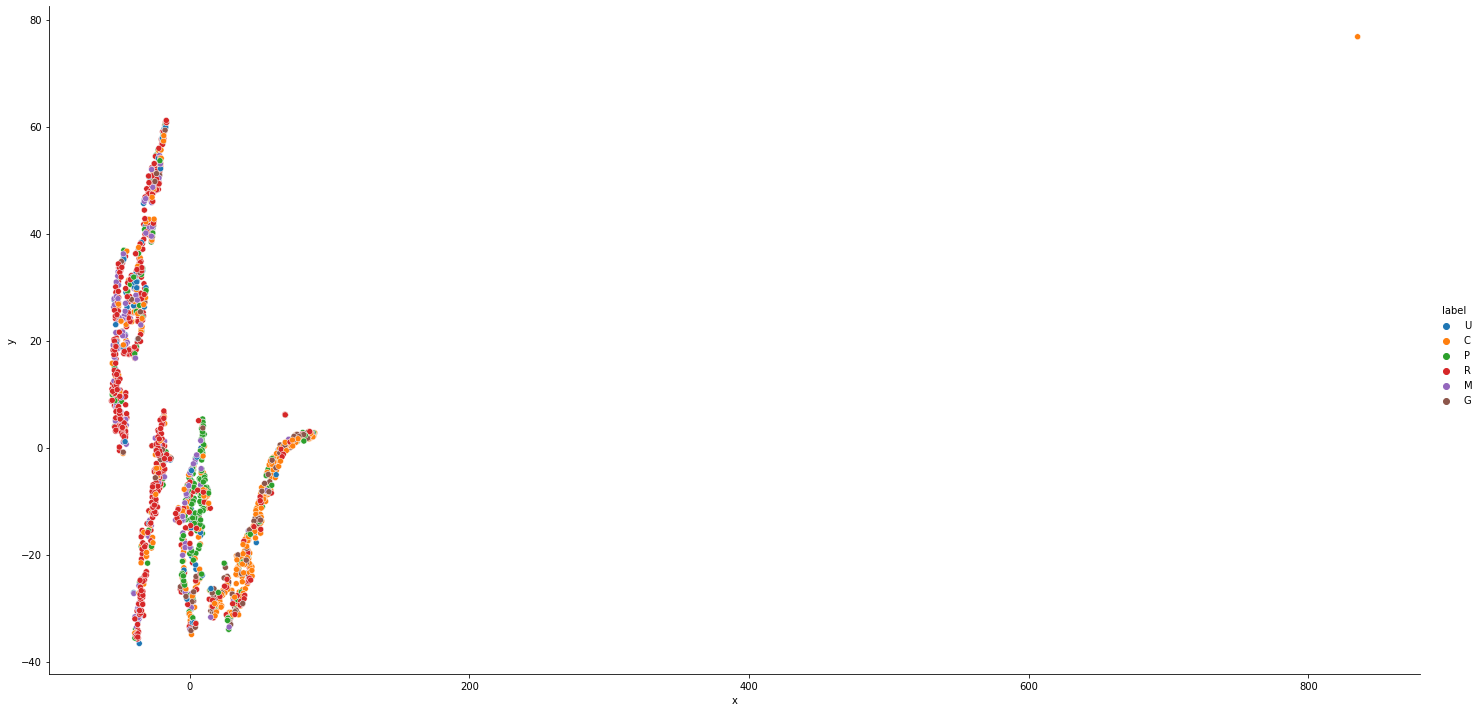

In [36]:
tsne = TSNE(n_components=2,init='pca',verbose=1)
emb_tsne = tsne.fit_transform(emb_64)
tmp = pd.DataFrame(dict(x=emb_tsne[:, 0], y=emb_tsne[:, 1], label=model.result['pred']))
sns.relplot(x='x', y='y', hue='label', data=tmp, height=10, aspect=2)